In [19]:
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage,SystemMessage
from langgraph.graph import StateGraph,START,END
from typing import TypedDict,Literal
from pydantic import BaseModel, Field


In [20]:
class Review(BaseModel):
    response:Literal["good","needs_improvement"]=Field(...,description="Review of the joke generated, either 'good' or 'needs_improvement'")

llm=ChatOllama(model="gemma3:4b",temperature=.5)
review_llm=llm.with_structured_output(Review)
model=ChatOllama(model="gemma3:270m",temperature=.5)

class IterativeState(TypedDict):
    topic:str
    input:str
    review:str
    approval:Literal["approved","pending"]
    current_step:int
    max_steps:int

In [21]:
def generate_joke(state:IterativeState):
    prompt=[
    SystemMessage(content="You are a witty comedian who crafts short, clever jokes."),    
    HumanMessage(content=f'''Generate a joke based on the topic: {state["topic"]} that follows these instructions:
    Rules:
    - Do NOT use question-answer format.
    - Max 280 characters.
    - Use observational humor, irony, sarcasm, or cultural references.
    - Think in meme logic, punchlines, or relatable takes.
    - Use simple, day to day english
    ''')]
    joke=model.invoke(prompt).content
    return {"input":joke}

In [22]:
state=IterativeState()
state["topic"]="Galaxy"
generate_joke(state)


{'input': 'Why did the galaxy get a bad grade? Because it was too much space! 🤷\u200d♀️\n'}

In [23]:
def get_review(state: IterativeState):
    prompt=[
        SystemMessage(content="You are a helpful assistant that reviews jokes. You will respond with either 'good' or 'needs_improvement'."),
        HumanMessage(content=f'''Review the following joke: {state['input']}. 
                     
                     Instructions: 
                     1. if the joke length is more than 280 characters, respond with 'needs_improvement'
                     2. if the joke length is 100 characters or less, respond with 'good'
                     3. if the joke is a question answer based joke, respond with 'needs_improvement'
                     ''')
    ]
    response = review_llm.invoke(prompt).response
    state["review"] = response
    return {"review": state["review"]}

In [24]:
state=IterativeState()
state["input"]="Why did the chicken cross the road? To get to the other side!"
get_review(state)

{'review': 'needs_improvement'}

In [33]:
def next_steps(state:IterativeState)->Literal["approved","pending"]:
    if (state["review"]=="good") or (state["current_step"]==state["max_steps"]):
        state["approval"]="approved"
        return "approved"
    else:
        state["approval"]="pending"
        return "pending"
    
def needs_improvement(state:IterativeState):
    prompt=[
        SystemMessage(content="You are a witty comedian who crafts short, clever jokes."),    
        HumanMessage(content=f'''The following joke needs improvement: {state["input"]}. 
        Improve the joke based on the following review: {state["review"]}.
        Rules:
        - Do NOT use question-answer format.
        - Max 280 characters.
        - Use observational humor, irony, sarcasm, or cultural references.
        - Think in meme logic, punchlines, or relatable takes.
        - Use simple, day to day english
        ''')
    ]
    joke=model.invoke(prompt).content
    new_step=state["current_step"]+1
    return {"input":joke,"current_step":new_step}


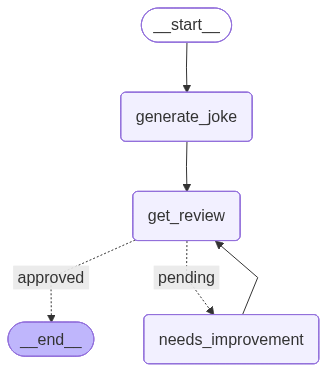

In [34]:
graph=StateGraph(IterativeState)
graph.add_node("generate_joke",generate_joke)
graph.add_node("get_review",get_review)
graph.add_node("needs_improvement",needs_improvement)

graph.add_edge(START,"generate_joke")
graph.add_edge("generate_joke","get_review")
graph.add_conditional_edges("get_review",next_steps,{"approved":END,"pending":"needs_improvement"})
graph.add_edge("needs_improvement","get_review")

workflow=graph.compile()
workflow

In [37]:
initial_state={
    "topic":"Galaxy",
    "current_step": 1,
    "max_steps":5
}

final_state=workflow.invoke(initial_state)
final_state

{'topic': 'Galaxy',
 'input': "Alright, buttercup! You've got a galaxy to conquer, and a telescope to admire. Why did the galaxy get a new telescope? 🤔 Because it's a *really* big star! 🌠..\n",
 'review': 'needs_improvement',
 'current_step': 5,
 'max_steps': 5}

In [42]:
import edge_tts
import asyncio


tts = edge_tts.Communicate(text=final_state["input"], voice="en-US-AvaNeural")
await tts.save("test.wav")
